In [131]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import pandas_datareader as web
import datetime as dt

# ML/DL imports
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Mean
from tensorflow import keras 


# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv("Kaggle_dataset/Stock.csv")
df.head()

Date   Open   High    Low  Close    Volume  Name
0  2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1  2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2  2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3  2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4  2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA

### NULL Check

In [4]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

### split dataset directly -> time series dataset

In [18]:
len(df)*0.9

2717.1

In [19]:
training_set = df.iloc[:2717,]
test_set = df.iloc[2717:,]
print(len(training_set))
print(len(test_set))

2717
302


### Visualizing and Plotting

In [20]:
fig = make_subplots()
fig.add_trace(go.Scatter(x = df["Date"], y = df["Open"], name = "Zoom"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

In [21]:
fig = make_subplots()
fig.add_trace(go.Scatter(x = training_set["Date"], y = training_set["Open"], name = "IBM Train"))
fig.add_trace(go.Scatter(x = test_set["Date"], y = test_set["Open"], name = "IBM Test"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

### Scaling the training data

In [24]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(training_set["Open"].values.reshape(-1, 1))
scaled_data.shape

(2717, 1)

### Training the model
The models uses 30 past days to predict the Open price 5 days later.  
If today we are DAY 50, we will use DAYS 20-49 to predict DAY 54  
```1~30일차, 2~31일차, . . .  2682~2712일차```

In [29]:
prdiction_days = 30

x_train = []
y_train = []

# from 30 to 2712
for day in range(prdiction_days, len(scaled_data)-5):
    # x에는 구간의 정보
    x_train.append(scaled_data[day-prediction_days:day, 0])
    # y에는 그 구간 마지막 날로부터 5일 후의 정보만 
    y_train.append(scaled_data[day+5, 0])        

In [33]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [34]:
print(x_train.shape)
print(y_train.shape)

(2682, 30, 1)
(2682,)


In [35]:
model = Sequential()  

## def은 글에서 만든 모델


In [72]:
def LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    
    # First LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1))) 
    model.add(Dropout(0.2))
    
    # Second LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, return_sequences = True))                                    
    model.add(Dropout(0.2))
    
    # Final LSTM layer with Dropout regularisation; Set return_sequences to False since now we will be predicting with the output layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

model = LSTM_model()
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath = 'best_weights.hdf5', verbose = 1, save_best_only = True)
his=model.fit(x_train,y_train,epochs=3, batch_size=32, callbacks=[checkpointer])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
dropout_39 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

## class는 내가 직접 만든 모델

In [157]:
class LSTM_class(tf.keras.Model):
    def __init__(self):
        super(LSTM_class, self).__init__()
        
        
        self.d1 = LSTM(units = 50, return_sequences = True, input_shape = (30,1))
        self.d2 = Dropout(0.2)
        
        self.d3 = LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1))
        self.d4 = Dropout(0.2)
        
        self.d5 = LSTM(units = 50, input_shape = (x_train.shape[1],1))
        self.d6 = Dropout(0.2)
        
        self.d7 = Dense(units = 1, activation  = "linear")
        
    # init에서 만든 layer를 불러와서 network 구성( 연산 파트 )
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        x = self.d6(x)
        x = self.d7(x)

        return x
    
    # def summary(self):
        # inputs = Input((30, 1))
        # Model(inputs, self.call(inputs)).summary()

In [162]:
keras.backend.clear_session()

model = LSTM_class() # model 클래스를 model 객체로 변경
temp_inputs = keras.Input(shape=(30, 1)) # model input image size
model(temp_inputs) # model input
model.summary() # 모델에 대한 요약 출력해줌

Model: "lstm_class"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  10400     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  20200     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_2 (LSTM)                multiple                  20200     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5

In [163]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath = 'best_weights.hdf5', verbose = 1, save_best_only = True)
    
his = model.fit(x_train, y_train, epochs=10, batch_size=32, callbacks=[checkpointer])

Epoch 1/10
84/84 [==============================] - 6s 27ms/step - loss: 0.0352 - accuracy: 3.4097e-04
Epoch 2/10
84/84 [==============================] - 2s 25ms/step - loss: 0.0044 - accuracy: 5.6324e-04
Epoch 3/10
84/84 [==============================] - 2s 25ms/step - loss: 0.0037 - accuracy: 4.7863e-04
Epoch 4/10
84/84 [==============================] - 2s 26ms/step - loss: 0.0034 - accuracy: 1.5279e-04
Epoch 5/10
84/84 [==============================] - 2s 25ms/step - loss: 0.0039 - accuracy: 7.1305e-04
Epoch 6/10
84/84 [==============================] - 2s 27ms/step - loss: 0.0035 - accuracy: 4.5293e-04
Epoch 7/10
84/84 [==============================] - 2s 26ms/step - loss: 0.0030 - accuracy: 7.8938e-04
Epoch 8/10
84/84 [==============================] - 2s 27ms/step - loss: 0.0033 - accuracy: 0.0010
Epoch 9/10
84/84 [==============================] - 3s 30ms/step - loss: 0.0030 - accuracy: 7.2015e-04
Epoch 10/10
84/84 [==============================] - 2s 26ms/step - loss: 0.0

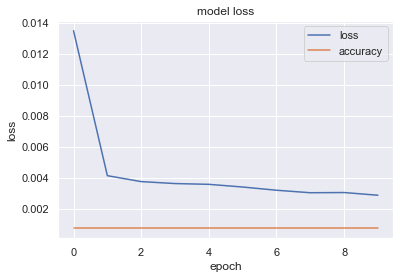

In [164]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'])
plt.show()

In [165]:
real_prices = test_set["Open"].values

# training, test 병합 후 training의 마지막날 30일과 training과 test, test가 input으로 들어가서
# 예측에 쓰일 것이다
total_dataset = pd.concat((training_set["Open"], test_set["Open"]), axis = 0)

len_train_data = len(total_dataset)-len(test_set["Open"])

model_inputs = total_dataset[len_train_data-prediction_days:].values

# -1 here indicated that we keep the same the dimension meaning dimension (3,) becomes here (3,1)
model_inputs = model_inputs.reshape(-1,1) 

# Normalzing the model inputs as we did previously but now for the test data inputs
model_inputs = scaler.transform(model_inputs)

In [166]:
x_test = []

# training 할 때 처럼 데이터 30일 단위로 나눠주고
for day in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[day-prediction_days:day,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# Predicting the prices
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices) 
# Have to inverse transform to "un-normalize" the values

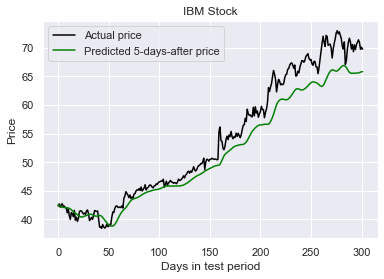

In [167]:
plt.plot(real_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label="Predicted 5-days-after price")
plt.title("IBM Stock")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend()
plt.show()

In [168]:
predicted_prices = predicted_prices.flatten()
predicted_prices

array([42.53014 , 42.38844 , 42.273933, 42.17749 , 42.10732 , 42.070995,
       42.05125 , 42.042057, 42.03075 , 42.013344, 41.963432, 41.899765,
       41.798702, 41.643112, 41.476883, 41.316372, 41.15727 , 41.03466 ,
       40.90772 , 40.783966, 40.645958, 40.50898 , 40.417816, 40.385956,
       40.408535, 40.46642 , 40.534958, 40.60673 , 40.66909 , 40.733746,
       40.8083  , 40.872967, 40.885666, 40.84792 , 40.77883 , 40.68317 ,
       40.59059 , 40.538998, 40.53373 , 40.56646 , 40.628323, 40.667606,
       40.628265, 40.50785 , 40.31626 , 40.094517, 39.858463, 39.619152,
       39.39059 , 39.199883, 39.043873, 38.920235, 38.83697 , 38.787693,
       38.803463, 38.909378, 39.092644, 39.3506  , 39.670578, 40.028954,
       40.391613, 40.732292, 41.037174, 41.29618 , 41.514114, 41.681934,
       41.851677, 42.048153, 42.290676, 42.561596, 42.832108, 43.06956 ,
       43.275192, 43.430237, 43.540874, 43.60585 , 43.6548  , 43.70135 ,
       43.763313, 43.848007, 43.948593, 44.06587 , 

In [170]:
training_set

Date   Open   High    Low  Close    Volume  Name
0     2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1     2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2     2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3     2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4     2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
...          ...    ...    ...    ...    ...       ...   ...
2712  2016-10-12  42.60  42.78  42.05  42.36   7290843  AABA
2713  2016-10-13  42.00  42.08  41.17  41.62  15689711  AABA
2714  2016-10-14  42.04  42.25  41.40  41.44   7781258  AABA
2715  2016-10-17  41.35  41.94  41.24  41.79   8620369  AABA
2716  2016-10-18  42.04  42.60  41.63  41.68  19360802  AABA

[2717 rows x 7 columns]

In [171]:
test_set

Date   Open   High    Low  Close    Volume  Name
2717  2016-10-19  42.30  42.94  42.26  42.73  14532469  AABA
2718  2016-10-20  42.69  42.69  42.07  42.38  11671022  AABA
2719  2016-10-21  42.10  42.20  41.73  42.17   7194168  AABA
2720  2016-10-24  42.50  42.68  42.38  42.59   4346851  AABA
2721  2016-10-25  42.72  42.75  42.43  42.55   5338875  AABA
...          ...    ...    ...    ...    ...       ...   ...
3014  2017-12-22  71.42  71.87  71.22  71.58  10979165  AABA
3015  2017-12-26  70.94  71.39  69.63  69.86   8542802  AABA
3016  2017-12-27  69.77  70.49  69.69  70.06   6345124  AABA
3017  2017-12-28  70.12  70.32  69.51  69.82   7556877  AABA
3018  2017-12-29  69.79  70.13  69.43  69.85   6613070  AABA

[302 rows x 7 columns]

In [174]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=training_set["Open"].index, y=training_set["Open"].values, name="IBM Train"))
fig.add_trace(go.Scatter(x=test_set["Open"].index, y=test_set["Open"].values, name="IBM Test"))
fig.add_trace(go.Scatter(x=test_set["Open"].index, y=predicted_prices, name="Predicted 5-days after price"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()